## Training with the Sinkhorn loss (results)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.stats import spearmanr
import json
from scipy.stats import norm
import ot
from scipy.spatial.distance import cdist
import wasserstein
from datetime import datetime
from collections import defaultdict
import torch
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
plt.rcParams.update({"font.size":15})

from geoemd.utils import space_cost_matrix, spacetime_cost_matrix
from geoemd.utils import spacetime_cost_matrix
from geoemd.loss.partial_ot import PartialOT

appl_name_mapping = {"charging": "Charging station occupancy", "traffic": "Traffic flow", "bikes": "Bike sharing demand", "carsharing": "Car sharing demand"}

def compute_pot(cost_matrix, pred_vals, real_vals, phi=0):
    ot_obj = PartialOT(cost_matrix, compute_exact=True, normalize_c=False, penalty_unb=phi)
    return ot_obj( torch.from_numpy(pred_vals).unsqueeze(0),
                   torch.from_numpy(real_vals).unsqueeze(0))


### Compare models trained with MSE loss vs Sinkhorn loss



In [2]:
# # evaluation scripts to produce the results:
# python scripts/evaluate.py -n cluster_03/traffic_01_02 --redo
# python scripts/evaluate.py -n cluster_03/charging_01_02 --redo
# python scripts/evaluate.py -n cluster_03/bikes_01_02 --redo

In [3]:
included_losses = ["basic", "emdsinkhornspatial"]
included_models = ["nhits"]

# for renames:
new_max_col_name = r"$W^{geo}_{\phi, c}$ ($\phi$ high)" #
new_total_col_name = r"total error \n ($\sum y - \sum \hat{y}$)"
new_01_col_name = r"$W^{geo}_{\phi, c}$ ($\phi$ low)" # r"OT unbalanced \n (low $\phi=$)"
new_0_col_name = r"OT unbalanced \n ($\phi=0$)"

all_res = []
for appl in ["charging", "bikes", "traffic"]:

    path = os.path.join("..", "data_submission", "sinkhorn_results", f"{appl}_results.csv")
    res = pd.read_csv(path)

    res["Application"] = appl_name_mapping[appl]
    # FILTER
    res = res[res["clustering"] == "kmeans"]
    res = res[res["loss"].isin(included_losses)]
    
    res["loss"] = res["loss"].map({
        "basic": "MSE loss",  "emdunbalancedspatial": "OT (Sinkhorn) loss",
        "emdinterpretablespatial": r"OT (Sinkhorn) loss ($\phi$=0.1 quantile)",
                                  "emdbalancedspatial": "balanced OT (Sinkhorn) loss", 
        "emdpartialspatial": r"Partial OT", #  (Sinkhorn) loss ($\phi$=0.1 quantile)",
        "emdmoransispatial": "Moran's I",
        "emdsinkhornspatial": "Sinkhorn loss"
    })

    res["Model"] = res["name"].apply(lambda x: "linear" if "linear" in x else "nhits")
    res = res[res["Model"].isin(included_models)]

    # print(res.columns)
    res.rename(
        columns={
            "EMD": "OT balanced", "loss": "Loss function",
            "unb_ot_quantile_1": new_01_col_name, "total_error": new_total_col_name,
            "Unb_OT_max": new_max_col_name, "unb_ot_quantile_0": new_0_col_name, "unb_ot_quantile_10": new_max_col_name
                }, inplace=True)
    
    res["clustering"] = res["clustering"].map({"agg": "Agglomerative", "kmeans": "KMeans"})
    if any(res["OT balanced"] < 0.1):
        res["OT balanced"]  = res["OT balanced"] * 100
        
    for ot_col in ["OT balanced", new_01_col_name, new_max_col_name, new_0_col_name]:
        if ot_col in res.columns and any(res[ot_col] > 1000):
            # print("Scaling unbalanced OT by 1000 for km")
            res[ot_col] = (res[ot_col] / 1000).round(1).astype(str)

    if len(included_models) > 1:
        res = res.sort_values("Model")
    else:
        res.drop("Model", axis=1, inplace=True)
    cleaned = res.set_index(["Application", "Loss function"])[
        [ "MSE", "OT balanced", new_01_col_name, new_max_col_name] # new_total_col_name  "OT (balanced)", "station-wise MAE", 
    ].round(2)
#     display(cleaned.sort_values("MSE"))
    all_res.append(cleaned)
all_res = pd.concat(all_res)
all_res

MSE OT balanced  \
Application                Loss function                       
Charging station occupancy MSE loss         0.34        32.7   
                           Sinkhorn loss    0.35        30.7   
Bike sharing demand        MSE loss         1.24       161.5   
                           Sinkhorn loss    1.26       135.7   
Traffic flow               MSE loss       852.53      1639.3   
                           Sinkhorn loss  876.63      1629.3   

                                         $W^{geo}_{\phi, c}$ ($\phi$ low)  \
Application                Loss function                                    
Charging station occupancy MSE loss                                  30.7   
                           Sinkhorn loss                             30.8   
Bike sharing demand        MSE loss                                 242.2   
                           Sinkhorn loss                            195.7   
Traffic flow               MSE loss                                1598.2   
                           Sinkhorn loss                           1565.9   

                                         $W^{geo}_{\phi, c}$ ($\phi$ high)  
Application                Loss function                                    
Charging station occupancy MSE loss                                   81.1  
                           Sinkhorn loss                              87.0  
Bike sharing demand        MSE loss                                 2406.1  
                           Sinkhorn loss                            1733.8  
Traffic flow               MSE loss                                 5892.3  
                           Sinkhorn loss                            5558.4

In [4]:
print(all_res.to_latex(float_format="%.2f"))

\begin{tabular}{llrlll}
\toprule
 &  & MSE & OT balanced & $W^{geo}_{\phi, c}$ ($\phi$ low) & $W^{geo}_{\phi, c}$ ($\phi$ high) \\
Application & Loss function &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Charging station occupancy} & MSE loss & 0.34 & 32.7 & 30.7 & 81.1 \\
 & Sinkhorn loss & 0.35 & 30.7 & 30.8 & 87.0 \\
\cline{1-6}
\multirow[t]{2}{*}{Bike sharing demand} & MSE loss & 1.24 & 161.5 & 242.2 & 2406.1 \\
 & Sinkhorn loss & 1.26 & 135.7 & 195.7 & 1733.8 \\
\cline{1-6}
\multirow[t]{2}{*}{Traffic flow} & MSE loss & 852.53 & 1639.3 & 1598.2 & 5892.3 \\
 & Sinkhorn loss & 876.63 & 1629.3 & 1565.9 & 5558.4 \\
\cline{1-6}
\bottomrule
\end{tabular}



## Plot how Partial OT depends on phi

In [6]:
appl = "charging"
example_data = pd.read_csv(os.path.join("..", "data_submission", "predictions", f"predictions_{appl}_nhits.csv"))
mapping = {"bikes": {'quantile_0': 0.0, 'quantile_1': 1424.9009716079063, 'quantile_2': 2163.5302137514627, 'quantile_3': 2833.208897403253, 'quantile_4': 3467.062337288329, 'quantile_5': 4099.205356615868, 'quantile_6': 4774.235901684952, 'quantile_7': 5531.465521523401, 'quantile_8': 6469.1733286045965, 'quantile_9': 7884.213058537715, 'quantile_10': 16607.942922148046},
           "charging": {'quantile_0': 0.0, 'quantile_1': 1719.258120832795, 'quantile_2': 2542.0890545468305, 'quantile_3': 3258.2662811664486, 'quantile_4': 3878.0832808730124, 'quantile_5': 4500.481923547142, 'quantile_6': 5087.704973510706, 'quantile_7': 5798.717847850787, 'quantile_8': 6626.705371481333, 'quantile_9': 7657.829889136122, 'quantile_10': 11531.482435504227, '1.5max': 17297.22365325634}
           }
x_variation = sorted(mapping[appl].values())
total_error = example_data["total_error"].mean()
emd1 = example_data["EMD"].mean()
ot_dist = example_data[[c for c in example_data.columns if "unb_ot" in c or "1.5max" in c]].mean().values

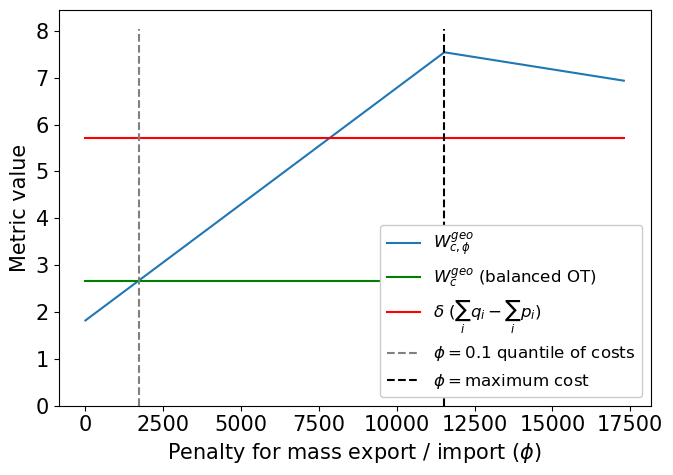

In [7]:
plt.figure(figsize=(7,5))
plt.plot(x_variation, ot_dist, label=r"$W^{geo}_{c, \phi}$") # "Unbalanced OT \n" + r"error (by $\phi$)"
plt.plot(x_variation, [emd1 for _ in range(len(x_variation))], label=r"$W^{geo}_c$ (balanced OT)", c="green")
plt.plot(x_variation, [total_error for _ in range(len(x_variation))], label=r"$\delta$ ($\sum_i q_i - \sum_i p_i$)", c="red") # label = Total observed - \ntotal predicted
plt.plot([mapping[appl]["quantile_1"] for _ in range(2)], [0, max(ot_dist)+0.5], label=r"$\phi=$0.1 quantile of costs", c="grey", linestyle="--")
plt.plot([mapping[appl]["quantile_10"] for _ in range(2)], [0, max(ot_dist)+0.5], label=r"$\phi=$maximum cost", c="black", linestyle="--")
plt.xlabel(r"Penalty for mass export / import ($\phi$)")
plt.ylim(0)
plt.ylabel("Metric value")
plt.legend(fontsize=12, framealpha=1)
plt.tight_layout()
# plt.savefig("figures/unbalanced_ot_explained.pdf")
plt.show()

## Compare transition matrices between OT loss and MSE loss

In [8]:
res_mse = pd.read_csv(os.path.join("..", "data_submission", "predictions", "predictions_traffic_nhits.csv"))
res_ot = pd.read_csv(os.path.join("..", "data_submission", "predictions", "predictions_traffic_nhits_sinkhorn.csv"))
dist_matrix = pd.read_csv(os.path.join("..", "data_submission", "data_raw", "traffic_cost.csv")).sort_values("station_id").set_index("station_id").values


In [9]:
def get_normed_vals(single_res_ot):
    pred_vals_normed = single_res_ot["pred"].values
    # get corresponding ground truth df
    gt_vals = single_res_ot["gt"].values
    # normalize pred by aligning to gt vals
    gt_vals_normed = gt_vals / np.sum(gt_vals) * np.sum(pred_vals_normed)
    return pred_vals_normed, gt_vals_normed


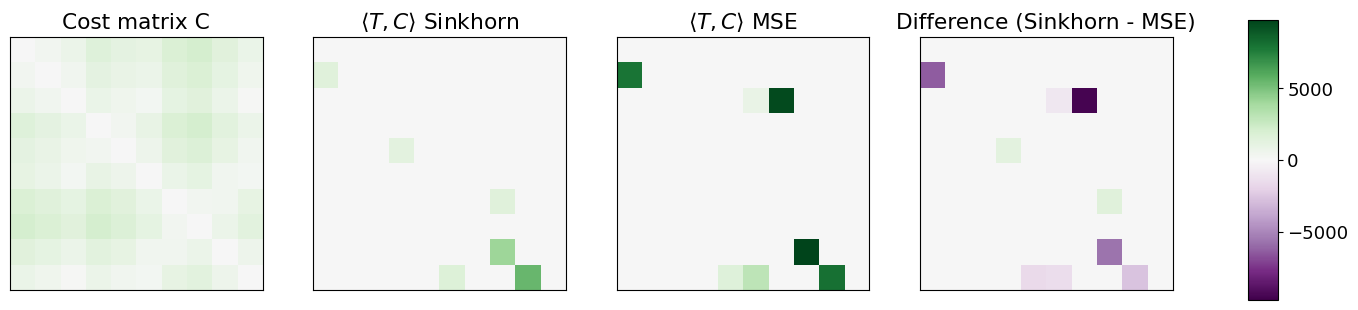

In [10]:
np.random.seed(7)
plt.rcParams.update({"font.size": 13})
cmap = "PRGn"
counter = 0
for val_sample_ind in res_mse["val_sample_ind"].unique():
    single_res_mse = res_mse[(res_mse["steps_ahead"] == 2) & (res_mse["val_sample_ind"] == val_sample_ind)].sort_values("group")
    single_res_ot = res_ot[(res_ot["steps_ahead"] == 2) & (res_ot["val_sample_ind"] == val_sample_ind)].sort_values("group")

    # compute T
    pred_vals_normed, gt_vals_normed = get_normed_vals(single_res_ot)
    T_ot = ot.emd(pred_vals_normed, gt_vals_normed, dist_matrix)

    pred_vals_normed, gt_vals_normed = get_normed_vals(single_res_mse)
    T_mse = ot.emd(pred_vals_normed, gt_vals_normed, dist_matrix)

    from sklearn.cluster import SpectralClustering
    n_clusters = 10
    clustering = SpectralClustering(n_clusters=n_clusters)
    # transform cost matrix into adjacency matrix
    adj_matrix = np.exp(
        -dist_matrix**2 / (2.0 * 1000**2)
    )
    clustering.fit(adj_matrix)
    selected_indices = np.where(clustering.labels_ == 5)[0]
    # cut to selected indices
    dist_matrix_cut = dist_matrix[selected_indices][:, selected_indices]
    T_ot = T_ot[selected_indices][:, selected_indices]
    T_mse = T_mse[selected_indices][:, selected_indices]

    if np.sum(T_ot * dist_matrix_cut) > np.sum(T_mse * dist_matrix_cut) / 2:
        continue

    vlim = np.max(T_mse * dist_matrix_cut)
    
    # plot
    fig = plt.figure(figsize=(15,7))

    plt.subplot(1, 4, 1)
    plt.title("Cost matrix C")
    plt.imshow(dist_matrix_cut, cmap=cmap, vmin=-vlim, vmax=vlim) # , vmin=0, vmax=vmax, cmap=cmap)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.imshow(T_ot * dist_matrix_cut, cmap=cmap, vmin=-vlim, vmax=vlim)
    # plt.colorbar()
    plt.title(r"$\langle T, C \rangle$ Sinkhorn")
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 4, 3)
    im = plt.imshow(T_mse * dist_matrix_cut, cmap=cmap, vmin=-vlim, vmax=vlim)
    plt.title(r"$\langle T, C \rangle$ MSE")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    im = plt.imshow(T_ot * dist_matrix_cut - T_mse * dist_matrix_cut, cmap="PRGn", vmin=-vlim, vmax=vlim)
                    # , cmap=cmap, vmin=0, vmax=vmax)
    plt.title(r"Difference (Sinkhorn - MSE)")
    plt.xticks([])
    plt.yticks([])

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
    fig.colorbar(im, cax=cbar_ax) # , label="transport cost (difference)")
    # plt.tight_layout()
    # plt.savefig(f"figures/transition_matrices.pdf", bbox_inches="tight")
    plt.show()
    counter += 1
    break

### Applications - time series plots

In [11]:
from geoemd.config import DATA_PATH

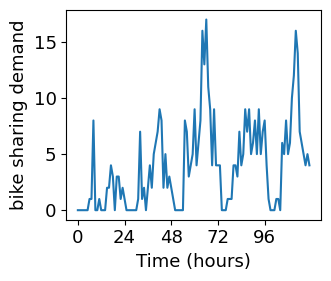

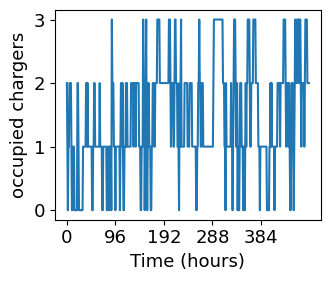

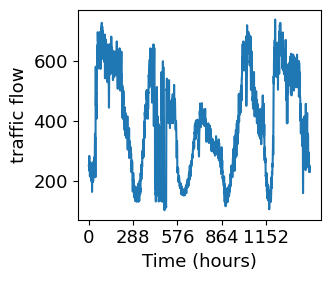

In [12]:
label = {"bikes": "bike sharing demand", "charging": "occupied chargers", "traffic": "traffic flow"}
frequ = {"bikes": 1, "charging": 4, "traffic": 12}
for appl in ["bikes" , "charging", "traffic"]:
    data = pd.read_csv(os.path.join("..", "data_submission", "data_raw", f"{appl}_data.csv"))
    
    if "station_id" in data.columns:
        data = data.pivot(
            index="timeslot", columns="station_id", values="count"
        ).fillna(0)
        use_column = data.sum().idxmax(axis=0)
    else:
        data.set_index("timeslot", inplace=True)
        use_column = "10"
    lim = int(24 * 5 * frequ[appl])
    plt.figure(figsize=(3.5,3))
    plt.plot(data[use_column][:lim])
    plt.ylabel(label[appl])
    ticks = np.arange(0, lim, int(24 * frequ[appl]))
    plt.xticks(ticks, ticks)
    plt.xlabel("Time (hours)")
    plt.tight_layout()
    # plt.savefig(f"figures/ts_{appl}.pdf")
    plt.show()